In [1]:
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import matplotlib.pyplot as plt
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
np.random.seed(20181111)

Using TensorFlow backend.


In [2]:
num_training=378
models = []
histories = []

def load_data():
    data = np.loadtxt('Trim_Removal_2.csv', delimiter=',', skiprows=1)
    #mean = np.mean(data, axis=0, keepdims=True)
    #delta = data - mean
    #std = np.sqrt(np.mean(delta**2, axis=0, keepdims=True))
    #data = delta / std
    
    #data_max = np.max(data, axis=0, keepdims=True)
    #data = data / data_max 
    
    np.random.shuffle(data) 
    
    X = data[:, 1:]
    y = data[:, 0]

    return X, y

X, y = load_data();
X, y = load_data();

print('Dataset: ', X.shape)

X_train = X[:num_training, :]
y_train = y[:num_training]

X_test = X[num_training:, :]
y_test = y[num_training:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Dataset:  (472, 15)
X_train shape: (378, 15)
y_train shape: (378,)
X_test shape: (94, 15)
y_test shape: (94,)


In [3]:
activation='relu'

def regularizer():
    return keras.regularizers.l2(0.0005)

dropout = 0.15
node_count = 28
#model
def build_mode():
    model = keras.models.Sequential([
        Dense(node_count, activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 2), activation=activation, kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 4), activation='relu', kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 6), activation='relu', kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(int(node_count / 6), activation='relu', kernel_initializer='normal', kernel_regularizer=regularizer()),
        Dropout(dropout),
        Dense(1)])


    def loss(y_true, y_pred):
        SS_res =  K.sum(K.square(y_true - y_pred)) 
        y_mean = K.mean(y_true)
        SS_reg = K.sum(K.square(y_pred - y_mean))
        SS_tot = SS_res + SS_reg
        print(K.int_shape(y_pred))
        return K.abs(SS_res/(SS_tot))
# getting r2
    def r2(y_true, y_pred):
        return 1.0 - loss(y_true, y_pred)

    
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                  loss=loss,
                  metrics=[r2, 'mse', 'mae', 'mape', 'cosine'])
    models.append(model)
    return model

wrapped_model = KerasRegressor(build_fn=build_mode)
#fit the model
history = wrapped_model.fit(X_train, y_train,batch_size=400, epochs=2000, verbose=0, validation_split=0.20)
#conducting permutation 
perm = PermutationImportance(wrapped_model).fit(X_test, y_test)

model = models[-1]
histories.append(history)


(None, 1)
(None, 1)
94/94 [==============================] - 0s 64us/step


In [4]:
eli5.show_weights(perm, top=None)


Weight,Feature
0.0009 ± 0.0067,x8
0.0007 ± 0.0005,x9
0.0005 ± 0.0005,x1
0.0003 ± 0.0008,x0
0.0000 ± 0.0000,x5
0.0000 ± 0.0002,x12
0.0000 ± 0.0000,x10
0.0000 ± 0.0000,x6
0.0000 ± 0.0000,x3
0.0000 ± 0.0000,x4


In [1]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)

NameError: name 'model' is not defined

In [6]:
score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

378/378 [==============================] - 0s 221us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.49959968826758167, 0.5010329554320643, 17.768553900340248, 2.0923204485070768, 423542802.6243386, 0.8677248664633938]


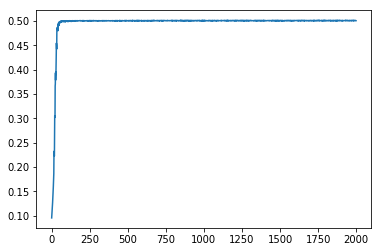

In [7]:
plot_begin = 0
history.history['r2'][plot_begin:]
plt.plot(history.history['r2'][plot_begin:])
#plt.plot(history.history['r2'][plot_begin:], label="Train")

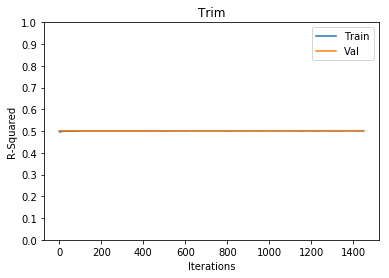

In [9]:
plot_begin = 50
# plot metrics

plt.plot(history.history['r2'][plot_begin:1500], label="Train")
plt.plot(history.history['val_r2'][plot_begin:1500], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.title('Trim')
#plt.yticks([i*0.1 for i in range(11)])
plt.legend()
plt.show()

94/94 [==============================] - 0s 82us/step
Test====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.4999844495286333, 0.5006482537756575, 8.622017485030154, 1.7535373733398762, 188339787.23404256, 0.8404255331830776]
378/378 [==============================] - 0s 58us/step
Train====
['loss', 'r2', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity']
[0.49959941610457403, 0.501033312429196, 17.759839567557844, 2.091389840242093, 423377105.43915343, 0.8677248664633938]


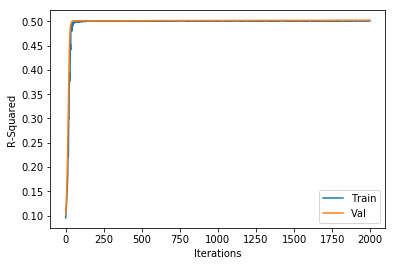

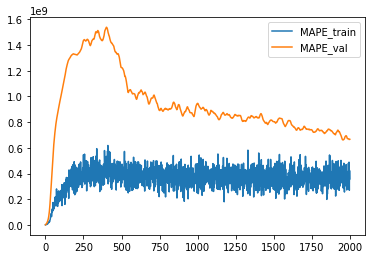

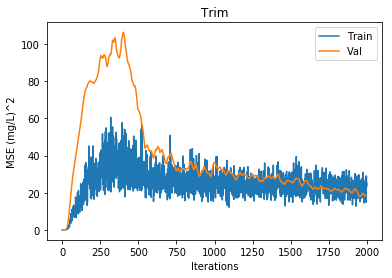

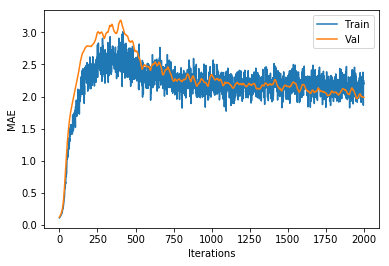

In [90]:
score_test = model.evaluate(X_test, y_test)
print("Test====")
print(model.metrics_names)
print(score_test)


score_train = model.evaluate(X_train, y_train)
print("Train====")
print(model.metrics_names)
print(score_train)

plot_begin = 0
# plot metrics

plt.plot(history.history['r2'][plot_begin:], label="Train")
plt.plot(history.history['val_r2'][plot_begin:], label="Val")
plt.ylabel('R-Squared')
plt.xlabel('Iterations')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_percentage_error'][plot_begin:], label="MAPE_train")
plt.plot(history.history['val_mean_absolute_percentage_error'][plot_begin:], label="MAPE_val")
plt.legend()
plt.show()

plt.plot(history.history['mean_squared_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_squared_error'][plot_begin:], label="Val")
plt.ylabel('MSE (mg/L)^2')
plt.xlabel('Iterations')
plt.title('Trim')
plt.legend()
plt.show()

plt.plot(history.history['mean_absolute_error'][plot_begin:], label="Train")
plt.plot(history.history['val_mean_absolute_error'][plot_begin:], label="Val")
plt.ylabel('MAE')
plt.xlabel('Iterations')
plt.legend()
plt.show()

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 38)                1482      
_________________________________________________________________
dropout_22 (Dropout)         (None, 38)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 19)                741       
_________________________________________________________________
dropout_23 (Dropout)         (None, 19)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 9)                 180       
_________________________________________________________________
dropout_24 (Dropout)         (None, 9)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 10        
Total para

In [111]:
data = np.loadtxt('Trim_Removal_2.csv', delimiter=',', skiprows=1)
results = np.zeros_like(data)
features = data[:, 1:]

for i in range(features.shape[1]):
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 1.05
    a = model.predict(input_data)
    input_data = np.array(features, copy=True)
    input_data[:, i] *= 0.95
    b = model.predict(input_data)
    
    results[:, i] = np.reshape((a - b) / b, (-1))

results[:, 0] = data[:, 0]

header = None
with open('Trim_Removal_2.csv', 'r') as f:
    header = f.readline().replace('\n', '')

np.savetxt('sensitivity_analysis_TR.csv', results, fmt='%.8f', delimiter=',', header=header, comments='')

In [49]:
history.history['val_r2'][1999]

0.29265081882476807

In [100]:
y_pred = model.predict(X_test, batch_size=180)

In [101]:
y_pred

array([[3.8011718],
       [4.07312  ],
       [4.201414 ],
       [3.7447574],
       [3.9047325],
       [4.1486406],
       [3.9603558],
       [4.1117396],
       [2.7058516],
       [4.209886 ],
       [4.084701 ],
       [3.8134165],
       [3.7934082],
       [3.9946282],
       [3.9273179],
       [2.4089203],
       [3.574252 ],
       [3.949491 ],
       [4.0884657],
       [3.8220608],
       [4.2226753],
       [4.0161963],
       [4.1119895],
       [4.134084 ],
       [3.85278  ],
       [4.218111 ],
       [3.7737443],
       [3.007832 ],
       [3.9122906],
       [2.4184904],
       [3.7560663],
       [4.11657  ],
       [4.2224193],
       [3.7974656],
       [4.0478845],
       [3.2596927],
       [4.1681495],
       [4.0467095],
       [4.1288385],
       [3.94394  ],
       [4.2027307],
       [3.8721962],
       [4.028664 ],
       [3.8411212],
       [3.965237 ],
       [3.942808 ],
       [4.2223454],
       [2.6825886],
       [4.110445 ],
       [3.2269137],


In [102]:
y_test

array([0.03, 0.01, 0.08, 0.28, 0.  , 0.34, 0.03, 0.34, 0.03, 0.08, 0.08,
       0.02, 1.95, 0.02, 0.07, 0.02, 0.  , 0.  , 0.  , 0.01, 0.08, 0.01,
       0.03, 0.  , 1.24, 1.85, 0.09, 0.  , 0.04, 0.09, 0.  , 0.  , 0.1 ,
       0.01, 0.01, 0.09, 0.01, 0.1 , 0.01, 0.04, 0.11, 0.38, 1.3 , 0.03,
       0.  , 0.14, 0.04, 0.02, 0.4 , 0.  , 0.  , 0.31, 0.01, 0.04, 0.16,
       0.04, 0.29, 0.  , 0.14, 0.01, 0.15, 0.02, 0.  , 0.22, 0.  , 0.03,
       0.1 , 0.71, 0.02, 0.08, 0.  , 0.08, 0.07, 0.05, 0.02, 0.02, 0.2 ,
       0.01, 0.12, 0.07, 0.07, 0.03, 0.02, 0.03, 0.1 , 0.01, 0.01, 0.02,
       0.03, 0.03, 0.16, 0.05, 0.04, 0.01])

In [103]:
np.savetxt("TR_2_Pre.csv", y_pred, delimiter=",")

In [104]:
np.savetxt("TR_2_Test.csv", y_test, delimiter=",")

In [105]:
data1 = np.loadtxt('TR_2_Pre.csv',delimiter=',',skiprows=0) 

In [106]:
data2 = np.loadtxt('TR_2_Test.csv',delimiter=',',skiprows=0) 

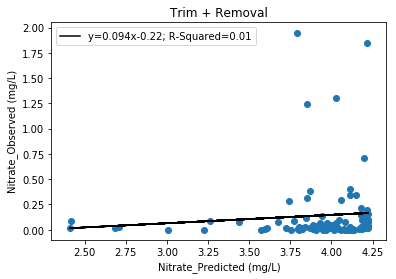

In [110]:
fit=np.polyfit(data1,data2,1)
fit_fn = np.poly1d(fit) 
plt.plot(data1, fit_fn(data1), '-k',label='y=0.094x-0.22; R-Squared=0.01')
plt.ylabel('Nitrate_Observed (mg/L)')
plt.xlabel('Nitrate_Predicted (mg/L)')
plt.title('Trim + Removal')
plt.legend()
plt.scatter(data1, data2)
plt.show()
